# Demo - Regression

In [2]:
import bayesnewton
import objax
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm, trange


## Data

In [3]:
def wiggly_time_series(x_, noise_var: float=0.2):
    # return 0.25 * (np.cos(0.04*x_+0.33*np.pi) * np.sin(0.2*x_) +
    return (np.cos(0.04*x_+0.33*np.pi) * np.sin(0.2*x_) +
            np.math.sqrt(noise_var) * np.random.normal(0, 1, x_.shape) +
            # np.math.sqrt(noise_var) * np.random.uniform(-4, 4, x_.shape) +
            0.0 * x_)  # 0.02 * x_)
            # 0.0 * x_) + 2.5  # 0.02 * x_)

### Train Data

In [4]:
np.random.seed(12345)
N = 100
x = np.linspace(-17, 147, num=N)

# observations
noise_var = 0.2
y = wiggly_time_series(x, noise_var)

### Test Data

In [5]:
x_test = np.linspace(np.min(x), np.max(x), num=500)
# x_test = np.linspace(-32.5, 157.5, num=250)
y_test = wiggly_time_series(x_test)
x_plot = np.linspace(np.min(x)-20.0, np.max(x)+100.0, 200)

In [6]:
x_forecast = np.linspace(np.max(x), np.max(x) + 100.0, num=50)
y_forecast = wiggly_time_series(x_forecast)

### Viz - Time Series

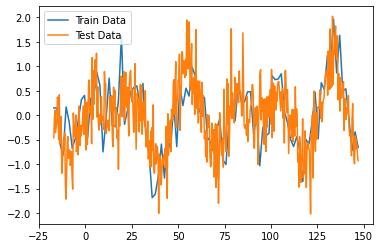

In [7]:
fig, ax = plt.subplots()

ax.plot(x, y, label="Train Data")
ax.plot(x_test, y_test, label="Test Data")
plt.legend()
plt.show()

## Model

### Inducing Points

In [8]:
# inducing points
M = 20
z = np.linspace(-30, 155, num=M)


### Batches

In [9]:

batch_size = N

### GP Model Params

In [10]:
var_f = 1.0  # GP variance
len_f = 5.0  # GP lengthscale
var_y = 0.2  # observation noise

In [18]:
x.shape, y.shape

((100,), (100,))

In [11]:
# Kernel function
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Periodic()
kern = bayesnewton.kernels.Sum([kern1, kern2])
# kern = kern1 + kern2

# likelihood function
lik = bayesnewton.likelihoods.Gaussian(variance=var_y)

# model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, Y=y)
model = bayesnewton.models.InfiniteHorizonVariationalGP(kernel=kern, likelihood=lik, X=x, Y=y)

### Optimization

In [12]:
lr_adam = 0.1
lr_newton = 1
opt_hypers = objax.optimizer.Adam(model.vars())


### Loss Function

In [13]:
energy = objax.GradValues(model.energy, model.vars())

In [14]:
@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op():
    # batch = np.random.permutation(N)[:batch_size]
    # model.inference(lr=lr_newton, batch_ind=batch, **inf_args)  # perform inference and update variational params
    # dE, E = energy(batch_ind=batch, **inf_args)  # compute energy and its gradients w.r.t. hypers
    model.inference(lr=lr_newton)  # perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    return E


In [15]:
train_op = objax.Jit(train_op)

### Training

In [16]:
iters = 500

losses = []
# t0 = time.time()
with trange(1, iters+1) as pbar:
    for i in pbar:
        loss = train_op()
        pbar.set_description(f'iter {i:2d}, energy: {loss[0]:1.4f}')
        
        losses.append(loss[0])

# print('optimisation time: %2.2f secs' % (t1-t0))

  0%|          | 0/500 [00:00<?, ?it/s]

## Results

In [21]:
nlpd = model.negative_log_predictive_density(X=x_test, Y=y_test)

print('nlpd: %2.3f' % nlpd)

nlpd: 0.746


### Loss Curve

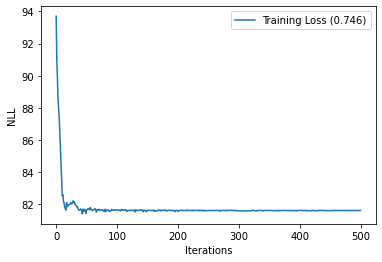

In [22]:
fig, ax = plt.subplots()

ax.plot(losses, label=f"Training Loss ({nlpd:2.3f})")
ax.set(xlabel="Iterations", ylabel="NLL")
plt.legend()
plt.show()

### Posterior Predictions

In [23]:
%%time

posterior_mean, posterior_var = model.predict_y(X=x_plot)

CPU times: user 4.82 s, sys: 106 ms, total: 4.92 s
Wall time: 4.64 s


In [24]:
# confidence intervals
lb = posterior_mean - 1.96 * posterior_var ** 0.5
ub = posterior_mean + 1.96 * posterior_var ** 0.5

#### Viz - Predictions

plotting ...


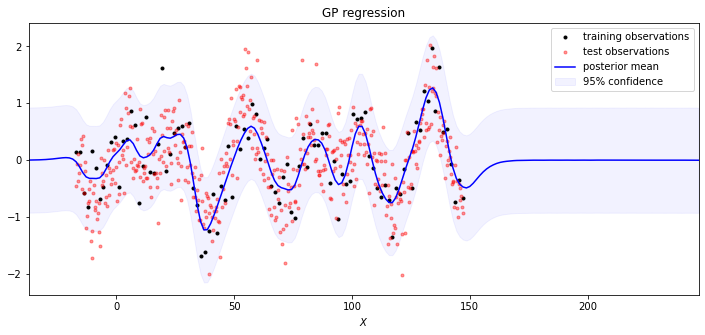

In [25]:
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
plt.plot(x, y, 'k.', label='training observations')
plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
plt.plot(x_plot, posterior_mean, 'b', label='posterior mean')
# plt.plot(x_plot, posterior_samples.T, 'b', alpha=0.2)
plt.fill_between(x_plot, lb, ub, color='b', alpha=0.05, label='95% confidence')
plt.xlim([x_plot[0], x_plot[-1]])
if hasattr(model, 'Z'):
    plt.plot(model.Z.value[:, 0], -2 * np.ones_like(model.Z.value[:, 0]), 'b^', markersize=5)
# plt.xlim([x_test[0], x_test[-1]])
# plt.ylim([-2, 5])
plt.legend()
plt.title('GP regression')
plt.xlabel('$X$')
plt.show()

### Posterior Samples

In [26]:
%%time

posterior_samples = model.posterior_sample(X=x_plot, num_samps=20)
posterior_mean = posterior_samples.mean(axis=0)

2021-12-03 14:05:19.866001: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Slow compile?  XLA was built without compiler optimizations, which can be slow.  Try rebuilding with -c opt.
Compiling module primitive_computation_scan__13.4096
********************************


CPU times: user 34 s, sys: 384 ms, total: 34.3 s
Wall time: 34.5 s


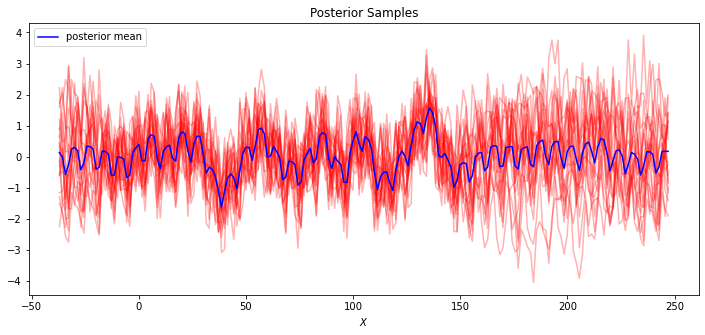

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))


ax.plot(x_plot, posterior_samples.T, color="red", alpha=0.3);
ax.plot(x_plot, posterior_mean, 'b', label='posterior mean')

plt.legend()
plt.title('Posterior Samples')
plt.xlabel('$X$')
plt.show()

### Forecast

In [88]:
%%time

x_forecast = np.linspace(np.max(x), np.max(x) + 100.0, num=50)
y_forecast = wiggly_time_series(x_forecast)

posterior_mean, posterior_var = model.predict_y(X=x_forecast)

UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with shape (5, 5) and dtype float64 to escape.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was smooth_prior_sample at /Users/eman/miniconda3/envs/jax_gp/lib/python3.9/site-packages/bayesnewton/basemodels.py:859 traced for scan.
------------------------------
The leaked intermediate value was created on line /Users/eman/miniconda3/envs/jax_gp/lib/python3.9/site-packages/bayesnewton/ops.py:838 (dare). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/Users/eman/miniconda3/envs/jax_gp/lib/python3.9/site-packages/bayesnewton/basemodels.py:860 (smooth_prior_sample)
/Users/eman/miniconda3/envs/jax_gp/lib/python3.9/site-packages/bayesnewton/basemodels.py:727 (predict)
/Users/eman/miniconda3/envs/jax_gp/lib/python3.9/site-packages/bayesnewton/basemodels.py:1230 (filter)
/Users/eman/miniconda3/envs/jax_gp/lib/python3.9/site-packages/bayesnewton/ops.py:929 (kalman_filter_infinite_horizon)
/Users/eman/miniconda3/envs/jax_gp/lib/python3.9/site-packages/bayesnewton/ops.py:838 (dare)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [44]:
# confidence intervals
lb = posterior_mean - 1.96 * posterior_var ** 0.5
ub = posterior_mean + 1.96 * posterior_var ** 0.5

TypeError: sub got incompatible shapes for broadcasting: (50, 2), (50, 4).

In [ ]:
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
# plt.plot(x, y, 'k.', label='training observations')
plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
plt.plot(x_forecast, y_forecast, 'r', alpha=0.4, label='test observations (Forecast)')
plt.plot(x_forecast, posterior_mean, 'b', label='posterior mean (Forecast)')
# plt.plot(x_plot, posterior_samples.T, 'b', alpha=0.2)
plt.fill_between(x_forecast, lb, ub, color='b', alpha=0.05, label='95% confidence (Forecast)')
plt.xlim([x_plot[120], x_forecast[-1]])
# if hasattr(model, 'Z'):
#     plt.plot(model.Z.value[:, 0], -2 * np.ones_like(model.Z.value[:, 0]), 'b^', markersize=5)
# plt.xlim([x_test[0], x_test[-1]])
# plt.ylim([-2, 5])
plt.legend()
plt.title('GP regression')
plt.xlabel('$X$')
plt.show()